In [1]:
from scripts.get_data import get_processed_data
from scripts.models import VotingClassifier

In [2]:
# logistic regression
from sklearn.linear_model import LogisticRegression 
# elastic net 
from sklearn.linear_model import ElasticNet
# svm classifier
from sklearn.svm import SVC
# lda 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [3]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

data, labels = get_processed_data(corr_thresh=0.9, minmax_scale=True, var_thresh=0.01, k_to_select='all')

In [4]:
from timeit import default_timer as timer   

## Ensemble model

This uses an implementation of the ensemble model as described in the paper. This is so that we can use this as a baseline to make comparisons.

In [4]:
model = VotingClassifier(20, SVC(kernel='linear'))
model.train(data.values, labels)
predictions = model.predict(data.values)

In [5]:
from sklearn.metrics import mean_absolute_error, accuracy_score

mean_absolute_error(labels, predictions), accuracy_score(labels, predictions)

(0.0, 1.0)

We have 100% accuracy on the training data when the `N` different models are all `SVC()`. 

In [36]:
from sklearn.base import BaseEstimator, clone
import pandas as pd
import numpy as np

class HierarchicalModel():
    def __init__(
        self,
        num_bins: int,
        bin_predictor: BaseEstimator,
        output_predictor: BaseEstimator,
        task_type: str = 'classification'
    ) -> None:
        self.num_bins = num_bins
        self.binner = clone(bin_predictor)
        self.predictors = []
        for _ in range(num_bins):
            self.predictors.append(clone(output_predictor))
        self.task_type = task_type
    
    def fit(self, X: np.array, y: np.array):
        y_sort = np.sort(y)
        # y_sort = y.sort_values(inplace=False)
        self.bin_endpts = []
        for bin in range(1, self.num_bins):
            self.bin_endpts.append(y_sort[int(bin * len(y) / self.num_bins)])
        y_transformed_list = []
        for i in range(len(y)):
            bin = 0
            for j, endpt in enumerate(self.bin_endpts):
                if endpt > y[i]:
                    bin = j
                    break
            y_transformed_list.append(bin)
        # y_transformed = pd.Series(y_transformed_list, index=y.index)
        y_transformed = np.array(y_transformed_list)
        # X_bins = []
        # y_bins = []
        self.binner.fit(X, y_transformed)
        for bin in range(self.num_bins):
            X_bin = X[y_transformed == bin]
            y_bin = y[y_transformed == bin]
            if len(X_bin.shape) == 1:
                X_bin = X_bin.reshape(1, -1)
        # for bin in range(self.num_bins):
            if len(y_bin) > 0:
                self.predictors[bin].fit(X_bin, y_bin)
    
    def predict(self, X: np.array):
        # X_arr = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        # pred_bins = pd.Series(self.binner.predict(X), index=X.index)
        pred_bins = self.binner.predict(X)
        # X_bins = []
        # y_bins = []
        preds = []
        for i in range(len(X)):
            preds.append(self.predictors[pred_bins[i]].predict(np.array(X[i]).reshape(1, -1)))
        preds = np.array(preds).reshape(-1,)
        return preds
    

In [37]:
model = HierarchicalModel(4, SVC(), SVC())

In [45]:
data_arr = np.array(data)
labels_arr = np.array(labels)

In [47]:
model.fit(data_arr, labels_arr)

In [48]:
model.predict(data_arr[0])

array([19])

## Leave One Out scoring

In [49]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression
from warnings import simplefilter, catch_warnings
import numpy as np

splitter = LeaveOneOut()
true_labels = []
pred_labels = []
# base_estimator = LDA(solver='eigen', shrinkage='auto')
base_estimator = SVC(kernel='linear')
# base_estimator = LogisticRegression()
train_time, eval_time = 0.0, 0.0
# data_arr = np.array(data)
# labels_arr = np.array(labels)

with catch_warnings():
    simplefilter('ignore')
    for fold, (train_ind, val_ind) in enumerate(splitter.split(data)):
        # model = VotingClassifier(20, base_estimator)
        model = HierarchicalModel(4, SVC(), SVC(kernel='linear'))
        # model = LinearRegression()
        # model = LogisticRegression()
        # model = LDA(solver='eigen', shrinkage='auto')
        X_train = data.iloc[train_ind]
        Y_train = labels.iloc[train_ind]
        X_val = data.iloc[val_ind]
        Y_val = labels.iloc[val_ind]
        feat_sel = SelectKBest(score_func=f_regression, k=1000)
        X_train_sel = feat_sel.fit_transform(X_train, Y_train)
        X_val_sel = feat_sel.transform(X_val)
        train_timer = timer()
        model.fit(X_train_sel, np.array(Y_train))
        train_time += timer() - train_timer
        eval_timer = timer()
        pred = model.predict(X_val_sel).reshape(-1,)
        eval_time += timer() - eval_timer
        # print(Y_val, pred)
        true_labels.append(np.array(Y_val)[0])
        pred_labels.append(pred[0])
        print(f'[Fold {fold+1}/{splitter.get_n_splits(data)}] ==> True label: {true_labels[-1]}, Prediction: {pred_labels[-1]}')

print(f'Average train time: {(train_time / splitter.get_n_splits(data)):.6f} s, average eval time: {(eval_time / splitter.get_n_splits(data)):.6f} s')

[Fold 1/133] ==> True label: 19, Prediction: 20
[Fold 2/133] ==> True label: 19, Prediction: 20
[Fold 3/133] ==> True label: 19, Prediction: 19
[Fold 4/133] ==> True label: 19, Prediction: 19
[Fold 5/133] ==> True label: 20, Prediction: 19
[Fold 6/133] ==> True label: 20, Prediction: 19
[Fold 7/133] ==> True label: 31, Prediction: 20
[Fold 8/133] ==> True label: 31, Prediction: 16
[Fold 9/133] ==> True label: 32, Prediction: 75
[Fold 10/133] ==> True label: 32, Prediction: 37
[Fold 11/133] ==> True label: 33, Prediction: 19
[Fold 12/133] ==> True label: 33, Prediction: 19
[Fold 13/133] ==> True label: 37, Prediction: 19
[Fold 14/133] ==> True label: 37, Prediction: 33
[Fold 15/133] ==> True label: 37, Prediction: 68
[Fold 16/133] ==> True label: 39, Prediction: 19
[Fold 17/133] ==> True label: 51, Prediction: 69
[Fold 18/133] ==> True label: 52, Prediction: 37
[Fold 19/133] ==> True label: 55, Prediction: 37
[Fold 20/133] ==> True label: 57, Prediction: 50
[Fold 21/133] ==> True label:

In [50]:
import numpy as np

mean_error = mean_absolute_error(np.array(true_labels), np.array(pred_labels))
median_error = median_absolute_error(np.array(true_labels), np.array(pred_labels))
mean_error, median_error

(13.308270676691729, 5.0)

In [51]:
from sklearn.metrics import r2_score

r2 = r2_score(np.array(true_labels), np.array(pred_labels))
r2

0.4450192462815111

Text(0, 0.5, 'Predictions')

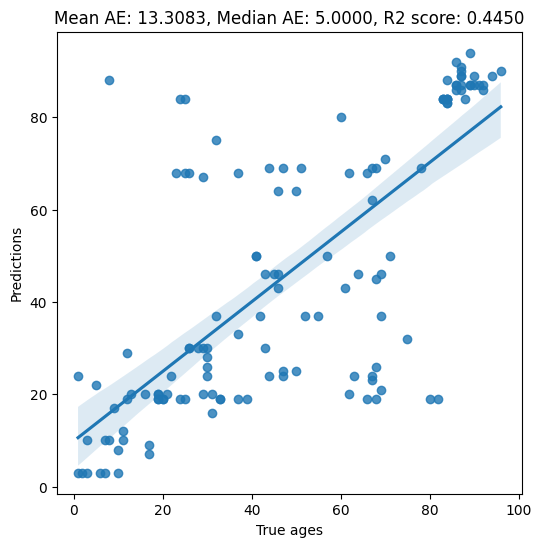

In [52]:
from seaborn import regplot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
regplot(x=true_labels, y=pred_labels)
plt.title(f'Mean AE: {mean_error:.4f}, Median AE: {median_error:.4f}, R2 score: {r2:.4f}')
plt.xlabel('True ages')
plt.ylabel('Predictions')

In [19]:
coefs = np.abs(model.coef_)
coefs.sort()
coefs

array([5.45044700e-05, 8.70455709e-05, 1.15935181e-04, ...,
       2.11463871e+00, 2.25569893e+00, 2.34520181e+00])

In [20]:
coefs[-10:]

array([1.7042112 , 1.73475889, 1.74589329, 1.77024618, 1.77759588,
       1.77976944, 1.95872393, 2.11463871, 2.25569893, 2.34520181])